🧠 Cell 1 — Imports, seeds, config

In [1]:
# --- Core / DS ---
import os, json, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Data fetch & calendars ---
import yfinance as yf
import pandas_market_calendars as mcal

# --- ML ---
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- DL ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, metrics, backend as K

warnings.filterwarnings("ignore")

# Repro
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print("TF:", tf.__version__)
print("GPU(s):", tf.config.list_physical_devices("GPU"))

# ---- Runner config (MUST match your saved AAPL-High model) ----
LOOKBACK        = 60          # use the same lookback used to train base_aapl_high
TRIM_YEARS      = 10
CALENDAR        = "XNYS"
MAX_FUTURE_DAYS = 252

# Fine-tune (only when ticker != AAPL); weights are NOT saved
FT_EPOCHS       = 60
FT_BATCH_SIZE   = 64
FT_LR           = 1e-4

# Bundles
HIGH_BASE_DIR   = "models/base_aapl_high"  # AAPL-High base you saved (model.keras, scaler.pkl)
CLOSE_BASE_DIR  = "models/base_aapl"       # optional: used to build prev-close path for forecasting

# Tiny custom metric stub (if your base registered it)
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1.0 - ss_res / (ss_tot + K.epsilon())


TF: 2.20.0
GPU(s): []


✅ Cell 2 — Sanity check that base bundles exist

In [2]:
def _check_bundle(path, name):
    m = os.path.join(path, "model.keras")
    s = os.path.join(path, "scaler.pkl")
    ok = os.path.exists(m) and os.path.exists(s)
    print(f"{name} bundle @ {path}: {'OK' if ok else 'MISSING'}")
    if ok:
        print("  ", os.path.basename(m), "|", os.path.basename(s))
    return ok

have_high  = _check_bundle(HIGH_BASE_DIR,  "AAPL-High")
have_close = _check_bundle(CLOSE_BASE_DIR, "AAPL-Close (optional)")

if not have_high:
    raise FileNotFoundError("AAPL-High base bundle missing. Train & save it first (step 7 earlier).")


AAPL-High bundle @ models/base_aapl_high: OK
   model.keras | scaler.pkl
AAPL-Close (optional) bundle @ models/base_aapl: OK
   model.keras | scaler.pkl


In [3]:
import time
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_market_calendars as mcal

def _last_completed_utc_day():
    return (pd.Timestamp.utcnow().normalize() - pd.Timedelta(days=1))

def _utc_midnight_naive(ts):
    ts = pd.Timestamp(ts)
    if ts.tzinfo is None or ts.tz is None:
        ts = ts.tz_localize("UTC")
    else:
        ts = ts.tz_convert("UTC")
    return ts.normalize().tz_localize(None)

def _resolve_dates(start=None, end=None):
    s = pd.Timestamp(start) if start else pd.Timestamp("2000-01-01")
    e = pd.Timestamp(end)   if end   else _last_completed_utc_day()
    return _utc_midnight_naive(s), _utc_midnight_naive(e)

def _flatten_columns(cols, ticker_expected=None):
    if isinstance(cols, pd.MultiIndex):
        if cols.nlevels == 2:
            sec = {t for (_, t) in cols}
            if len(sec) == 1 and (ticker_expected is None or list(sec)[0] == ticker_expected):
                flat = [str(f) for (f, _) in cols]
            else:
                flat = ["_".join([str(x) for x in tup if x is not None]) for tup in cols]
        else:
            flat = ["_".join([str(x) for x in tup if x is not None]) for tup in cols]
    else:
        flat = [str(c) for c in cols]
    return [c.strip().title().replace(" ", "_") for c in flat]

def fetch_ohlcv_yf(ticker, start_dt, end_dt, auto_adjust=True, max_retries=3, sleep_sec=1.5):
    start_s, end_s = str(start_dt.date()), str(end_dt.date())
    last_err = None
    for attempt in range(1, max_retries+1):
        try:
            df = yf.download(
                tickers=ticker, start=start_s, end=end_s,
                auto_adjust=auto_adjust, progress=False, threads=True, group_by="column"
            )
            if df is None or df.empty:
                raise ValueError(f"No data for {ticker} in {start_s}→{end_s}")

            df.index = pd.to_datetime(df.index, utc=False)
            if getattr(df.index, "tz", None) is not None:
                df.index = df.index.tz_localize(None)
            df = df.sort_index().loc[~df.index.duplicated(keep="first")]
            df.columns = _flatten_columns(df.columns, ticker_expected=ticker.upper())
            for c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce")
            df = df.dropna(how="all")

            # Align to exchange calendar
            cal = mcal.get_calendar(CALENDAR)
            sched = cal.schedule(start_date=start_s, end_date=end_s)
            idx = sched.index
            if getattr(idx, "tz", None) is not None:
                idx = idx.tz_localize(None)
            idx = pd.DatetimeIndex(idx)
            df = df.loc[df.index.intersection(idx)]

            need = {"High", "Close"}
            if not need.issubset(set(df.columns)):
                raise ValueError(f"Missing columns: {need - set(df.columns)}")
            df = df.dropna(subset=["High", "Close"])
            if df.empty:
                raise ValueError("All rows dropped after cleaning.")
            return df
        except Exception as e:
            last_err = e
            if attempt < max_retries:
                time.sleep(sleep_sec)
            else:
                raise RuntimeError(f"Fetch failed after {max_retries} attempts: {e}") from e

def create_sequences_std_high(data_scaled: pd.DataFrame, prev_close_series: pd.Series, lookback: int):
    """
    Build sequences from standardized HighLogRet.
    For each target at time t, we carry Prev_Close_t to reconstruct:
        Ĥ_t = Prev_Close_t * exp(r̂_high_t)
    """
    X, y, pc = [], [], []
    vals = data_scaled["HighLogRet"].values
    prev_vals = prev_close_series.reindex(data_scaled.index).values  # aligned to t
    for i in range(lookback, len(vals)):
        X.append(vals[i-lookback:i].reshape(lookback,1))
        y.append(vals[i])
        pc.append(prev_vals[i])
    return (np.asarray(X, np.float32),
            np.asarray(y, np.float32),
            np.asarray(pc, np.float32))

def future_trading_days(last_date: pd.Timestamp, n: int) -> pd.DatetimeIndex:
    cal = mcal.get_calendar(CALENDAR)
    start_d = (last_date + pd.Timedelta(days=1)).date()
    end_d   = (last_date + pd.DateOffset(days=max(10, n*3))).date()
    sched = cal.schedule(start_date=start_d, end_date=end_d)
    idx = sched.index
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_localize(None)
    idx = pd.DatetimeIndex(idx)[:n]
    if len(idx) < n: raise ValueError("Not enough future trading days.")
    return idx


🧪 Cell 4 — prep_high_for_ticker() (fetch → target → split → scaler → sequences)

In [4]:
from sklearn.preprocessing import StandardScaler
import joblib

def prep_high_for_ticker(ticker: str):
    """
    Returns everything needed to train/finetune/infer for HIGH:
      - hc: trimmed High/Close
      - high_df: DataFrame with ['High','Prev_Close','HighLogRet']
      - splits: train/val/test (raw + scaled)
      - sequences: X_*, y_*, pc_*
      - scaler: StandardScaler (AAPL = load base scaler; else fit on train)
    """
    ticker = ticker.upper().strip()
    start_dt, end_dt = _resolve_dates(None, None)
    raw = fetch_ohlcv_yf(ticker, start_dt, end_dt, auto_adjust=True)

    # Keep High/Close and trim recent years
    hc = raw[["High","Close"]].copy()
    cutoff = hc.index.max() - pd.DateOffset(years=TRIM_YEARS)
    hc = hc[hc.index >= cutoff].copy()

    # Target: HighLogRet = ln(High_t / Close_{t-1})
    prev_close = hc["Close"].shift(1)
    high_logret = np.log(hc["High"] / prev_close)
    high_df = pd.DataFrame({
        "High": hc["High"],
        "Prev_Close": prev_close,
        "HighLogRet": high_logret
    }).dropna()

    # Splits (70/15/15)
    n = len(high_df)
    if n < LOOKBACK + 200:
        raise ValueError(f"Not enough rows after trim/diff: have {n}, need ≥ {LOOKBACK+200}.")
    train_end = int(n*0.70); val_end = int(n*0.85)
    train_df = high_df.iloc[:train_end].copy()
    val_df   = high_df.iloc[train_end:val_end].copy()
    test_df  = high_df.iloc[val_end:].copy()

    # Scaler: AAPL uses saved base scaler; others fit fresh on TRAIN
    if ticker == "AAPL":
        base_scaler_path = os.path.join(HIGH_BASE_DIR, "scaler.pkl")
        assert os.path.exists(base_scaler_path), "Missing base AAPL-High scaler.pkl"
        scaler = joblib.load(base_scaler_path)
    else:
        scaler = StandardScaler().fit(train_df[["HighLogRet"]])

    def _scale(df):
        return pd.DataFrame(
            scaler.transform(df[["HighLogRet"]]),
            index=df.index, columns=["HighLogRet"]
        )

    train_sc = _scale(train_df)
    val_sc   = _scale(val_df)
    test_sc  = _scale(test_df)

    # LSTM sequences (standardized HighLogRet), plus Prev_Close for reconstruction
    X_train, y_train, pc_train = create_sequences_std_high(train_sc, train_df["Prev_Close"], LOOKBACK)
    X_val,   y_val,   pc_val   = create_sequences_std_high(val_sc,   val_df["Prev_Close"],   LOOKBACK)
    X_test,  y_test,  pc_test  = create_sequences_std_high(test_sc,  test_df["Prev_Close"],  LOOKBACK)

    # Summary
    print(f"✅ {ticker} prepared | rows={n} | range {high_df.index.min().date()} → {high_df.index.max().date()}")
    print("Sequences:",
          "X_train", X_train.shape, "| X_val", X_val.shape, "| X_test", X_test.shape)
    if ticker == "AAPL":
        print("Scaler: loaded base (AAPL-High)")
    else:
        print("Scaler: fitted on TRAIN (ticker-specific)")

    return {
        "hc": hc, "high_df": high_df,
        "train_df": train_df, "val_df": val_df, "test_df": test_df,
        "train_sc": train_sc, "val_sc": val_sc, "test_sc": test_sc,
        "X_train": X_train, "y_train": y_train, "pc_train": pc_train,
        "X_val":   X_val,   "y_val":   y_val,   "pc_val":   pc_val,
        "X_test":  X_test,  "y_test":  y_test,  "pc_test":  pc_test,
        "scaler": scaler
    }


🧑‍💻 Cell 5 — Get inputs & prep data (fetch → target → split → scaler → sequences)

In [5]:
# Step 3 — Runner: inputs & data prep

# 1) User inputs
try:
    ticker = input("Enter ticker for HIGH forecast (e.g., AAPL, MSFT, NVDA): ").strip().upper()
except EOFError:
    ticker = "AAPL"
ticker = ticker or "AAPL"

try:
    rawN = input(f"Enter FUTURE trading days to forecast (1–{MAX_FUTURE_DAYS}) [Enter=14]: ").strip()
except EOFError:
    rawN = ""
if rawN == "":
    N_FUTURE = 14
else:
    try:
        n = int(rawN); assert 1 <= n <= MAX_FUTURE_DAYS
        N_FUTURE = n
    except Exception:
        print("⚠️ Invalid N; using default 14."); N_FUTURE = 14

print(f"✅ Inputs → ticker={ticker}, N={N_FUTURE}")

# 2) Prep this ticker
bundle   = prep_high_for_ticker(ticker)
hc       = bundle["hc"]           # trimmed High/Close (DataFrame)
high_df  = bundle["high_df"]      # High, Prev_Close, HighLogRet
train_sc = bundle["train_sc"]; val_sc = bundle["val_sc"]; test_sc = bundle["test_sc"]
train_df = bundle["train_df"];   val_df = bundle["val_df"];   test_df = bundle["test_df"]
X_train, y_train, pc_train = bundle["X_train"], bundle["y_train"], bundle["pc_train"]
X_val,   y_val,   pc_val   = bundle["X_val"],   bundle["y_val"],   bundle["pc_val"]
X_test,  y_test,  pc_test  = bundle["X_test"],  bundle["y_test"],  bundle["pc_test"]
scaler   = bundle["scaler"]

print("Seq shapes →",
      "X_train", X_train.shape, "| X_val", X_val.shape, "| X_test", X_test.shape)


✅ Inputs → ticker=NVDA, N=10
✅ NVDA prepared | rows=2514 | range 2015-09-15 → 2025-09-12
Sequences: X_train (1699, 60, 1) | X_val (317, 60, 1) | X_test (318, 60, 1)
Scaler: fitted on TRAIN (ticker-specific)
Seq shapes → X_train (1699, 60, 1) | X_val (317, 60, 1) | X_test (318, 60, 1)


🧱 Cell 6 — Load AAPL-High base; fine-tune in RAM only if ticker ≠ AAPL

In [6]:
from tensorflow import keras
from tensorflow.keras import optimizers, losses, metrics
import joblib, os, json

# Load base AAPL-High model
high_model_path = os.path.join(HIGH_BASE_DIR, "model.keras")
assert os.path.exists(high_model_path), "Missing base AAPL-High model.keras"
model = keras.models.load_model(high_model_path, custom_objects={"r2_metric": r2_metric})

if ticker == "AAPL":
    print("🔹 Using base AAPL-High model (no fine-tune).")
else:
    print(f"🔸 Ephemeral fine-tune on {ticker} (no saving).")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=FT_LR),
        loss=losses.Huber(delta=1.0),
        metrics=[metrics.MAE, metrics.RootMeanSquaredError(name="rmse")]
    )
    _ = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=FT_EPOCHS, batch_size=FT_BATCH_SIZE,
        shuffle=False, verbose=1
    )
    print("✅ Fine-tune complete (RAM only).")


🔸 Ephemeral fine-tune on NVDA (no saving).
Epoch 1/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 0.3399 - mean_absolute_error: 0.6641 - rmse: 1.0025 - val_loss: 0.3731 - val_mean_absolute_error: 0.7205 - val_rmse: 1.1163
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.3375 - mean_absolute_error: 0.6633 - rmse: 0.9999 - val_loss: 0.3722 - val_mean_absolute_error: 0.7185 - val_rmse: 1.1151
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.3371 - mean_absolute_error: 0.6632 - rmse: 0.9982 - val_loss: 0.3721 - val_mean_absolute_error: 0.7180 - val_rmse: 1.1137
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.3330 - mean_absolute_error: 0.6540 - rmse: 0.9921 - val_loss: 0.3726 - val_mean_absolute_error: 0.7197 - val_rmse: 1.1131
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.3321 - mean_absolute_error: 0.6543 - rmse: 0.9925 - val_loss: 0.3725 - val_mean_absolute_error: 0.7197 - val_rmse: 1.1120
Epoch 6/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 

✅ Cell 7 — Validation on High price scale

📊 Validation — NVDA HIGH
  MAE : 0.6787
  RMSE: 1.2506
  MAPE: 1.73%
  R² accuracy : 99.5539 %


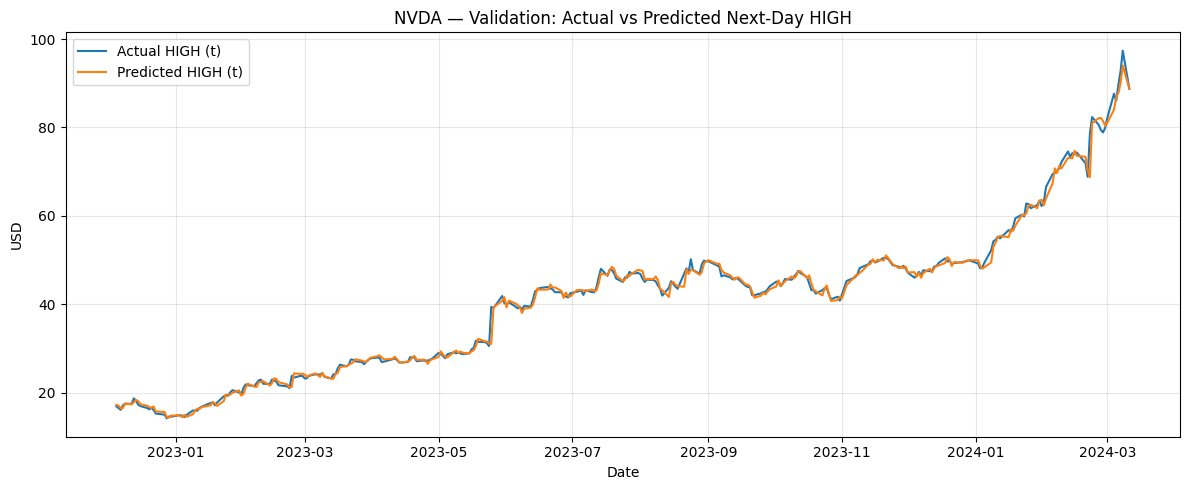

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Predict standardized HighLogRet on validation
y_pred_std = model.predict(X_val, verbose=0).ravel()
y_true_std = y_val.ravel()

# Back to log-returns, then reconstruct High: Ĥ_t = Prev_Close_t * exp(r̂_high_t)
y_pred_log = scaler.inverse_transform(y_pred_std.reshape(-1,1)).ravel()
y_true_log = scaler.inverse_transform(y_true_std.reshape(-1,1)).ravel()
pred_high  = pc_val * np.exp(y_pred_log)
true_high  = pc_val * np.exp(y_true_log)

# Metrics (price scale)
mae  = mean_absolute_error(true_high, pred_high)
rmse = mean_squared_error(true_high, pred_high)
mape = (np.abs((true_high - pred_high)/np.maximum(1e-8, np.abs(true_high)))).mean()*100
r2   = r2_score(true_high, pred_high)

print(f"📊 Validation — {ticker} HIGH")
print(f"  MAE : {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  R² accuracy : {r2*100:.4f} %")

# Plot
val_dates = val_df.index[LOOKBACK:]
plt.figure(figsize=(12,5))
plt.plot(val_dates, true_high, label="Actual HIGH (t)")
plt.plot(val_dates, pred_high, label="Predicted HIGH (t)")
plt.title(f"{ticker} — Validation: Actual vs Predicted Next-Day HIGH")
plt.xlabel("Date"); plt.ylabel("USD"); plt.grid(True, alpha=.3); plt.legend(); plt.tight_layout(); plt.show()


🔮 Cell 8 — Forecast N future HIGHs (uses Close base for prev-Close path when available)

ℹ️ Close LOOKBACK=90 differs from High LOOKBACK=60. Proceeding.
✅ Prev-Close path from Close base model.
✅ HIGH forecast ready:


,prev_close_used,pred_high_logret,pred_high
date,,,
2025-09-15,177.820007,0.016671,180.809212
2025-09-16,178.826797,0.014720,181.478534
2025-09-17,179.264984,0.013714,181.740379
2025-09-18,179.286072,0.013876,181.791136
2025-09-19,179.096695,0.012897,181.421486


,prev_close_used,pred_high_logret,pred_high
date,,,
2025-09-22,178.436417,0.011550,180.509321
2025-09-23,178.248505,0.011668,180.340534
2025-09-24,178.162384,0.011718,180.262345
2025-09-25,177.801697,0.010871,179.745139
2025-09-26,177.645370,0.011343,179.671886


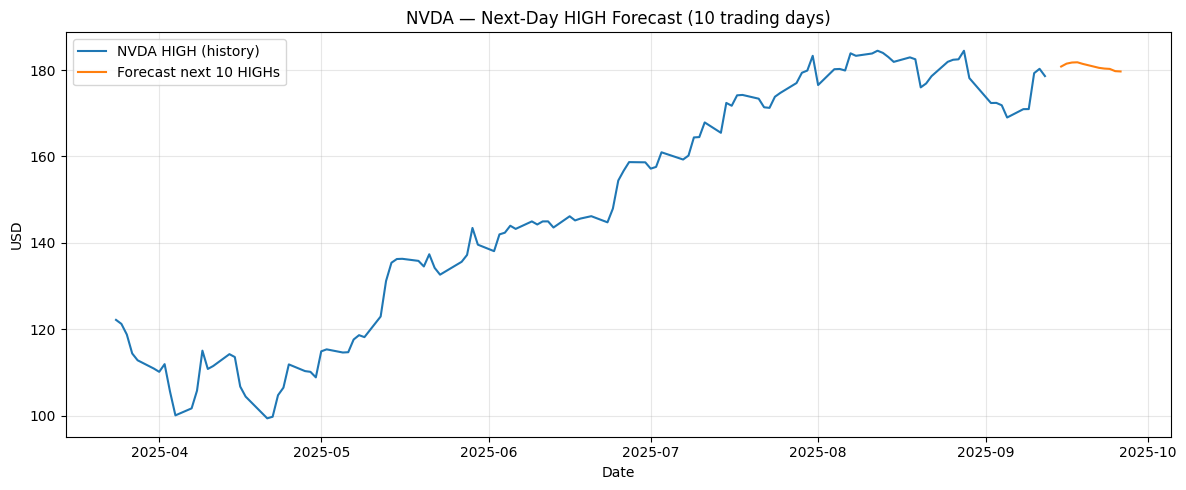

In [10]:
from tensorflow import keras
import joblib, json

# Try loading Close base bundle (optional but improves prev-close path realism)
CLOSE_LOOKBACK = LOOKBACK
def try_load_close_bundle():
    mpath = os.path.join(CLOSE_BASE_DIR, "model.keras")
    spath = os.path.join(CLOSE_BASE_DIR, "scaler.pkl")
    cpath = os.path.join(CLOSE_BASE_DIR, "config.json")
    if not (os.path.exists(mpath) and os.path.exists(spath)): return None, None, None
    try:
        cm = keras.models.load_model(mpath, custom_objects={"r2_metric": r2_metric})
        cs = joblib.load(spath)
        cc = json.load(open(cpath)) if os.path.exists(cpath) else {}
        return cm, cs, cc
    except Exception:
        return None, None, None

close_model, close_scaler, close_cfg = try_load_close_bundle()
if close_model is None:
    print("ℹ️ Close base bundle not found — will use fallback prev-Close drift.")
else:
    CLOSE_LOOKBACK = int(close_cfg.get("lookback", LOOKBACK)) if isinstance(close_cfg, dict) else LOOKBACK
    if CLOSE_LOOKBACK != LOOKBACK:
        print(f"ℹ️ Close LOOKBACK={CLOSE_LOOKBACK} differs from High LOOKBACK={LOOKBACK}. Proceeding.")

def build_prev_close_path_via_close_model(n_steps: int):
    if close_model is None: return None
    close_series = hc["Close"].copy()
    ret_close = pd.DataFrame({"LogRet": np.log(close_series).diff()}).dropna()
    std_close = pd.DataFrame(
        close_scaler.transform(ret_close[["LogRet"]]),
        index=ret_close.index, columns=["LogRet"]
    )
    L = CLOSE_LOOKBACK
    if len(std_close) < L: return None
    window = std_close.values[-L:].astype(np.float32).reshape(L, 1)
    last_close = float(close_series.iloc[-1])

    preds_close, cur, prev = [], window.copy(), last_close
    for _ in range(n_steps):
        y_std = float(close_model.predict(cur.reshape(1, L, 1), verbose=0).ravel()[0])
        y_log = float(close_scaler.inverse_transform([[y_std]])[0, 0])
        nxt   = prev * np.exp(y_log)
        preds_close.append(nxt)
        cur = np.vstack([cur[1:], [[y_std]]]); prev = nxt

    prev_closes = np.empty(n_steps, dtype=np.float32)
    prev_closes[0] = last_close
    if n_steps > 1: prev_closes[1:] = np.asarray(preds_close[:-1], dtype=np.float32)
    return prev_closes

def build_prev_close_path_fallback(n_steps: int):
    """Median-drift proxy if Close base missing."""
    close_series = hc["Close"].copy()
    lr = np.log(close_series).diff().dropna()
    drift = float(np.median(lr.tail(120))) if len(lr) else 0.0
    prev = float(close_series.iloc[-1])
    path = np.empty(n_steps, dtype=np.float32)
    for i in range(n_steps):
        if i == 0:
            path[i] = prev
        else:
            prev = prev * np.exp(drift)
            path[i] = prev
    return path

prev_close_path = build_prev_close_path_via_close_model(N_FUTURE)
if prev_close_path is not None:
    print("✅ Prev-Close path from Close base model.")
else:
    prev_close_path = build_prev_close_path_fallback(N_FUTURE)
    print("⚠️ Using fallback prev-Close path (drift proxy).")

# Seed window for High standardized returns
combined_std = pd.concat([train_sc["HighLogRet"], val_sc["HighLogRet"], test_sc["HighLogRet"]]).sort_index()
assert len(combined_std) >= LOOKBACK, "Not enough history to seed."
seed_window = combined_std.values[-LOOKBACK:].astype(np.float32).reshape(LOOKBACK, 1)

# Future trading dates
future_idx = future_trading_days(high_df.index.max(), N_FUTURE)

# Recursive rollout
pred_std, pred_log, pred_high_path, prev_used = [], [], [], []
cur = seed_window.copy()
for k in range(N_FUTURE):
    prev_for_step = float(prev_close_path[k])  # Close_{t-1}
    y_std = float(model.predict(cur.reshape(1, LOOKBACK, 1), verbose=0).ravel()[0])
    y_log = float(scaler.inverse_transform([[y_std]])[0, 0])
    h_hat = prev_for_step * np.exp(y_log)

    pred_std.append(y_std); pred_log.append(y_log); pred_high_path.append(h_hat); prev_used.append(prev_for_step)
    cur = np.vstack([cur[1:], [[y_std]]])  # slide with standardized prediction

forecast_high_df = pd.DataFrame({
    "prev_close_used": prev_used,
    "pred_high_logret": pred_log,
    "pred_high": pred_high_path,
}, index=future_idx)
forecast_high_df.index.name = "date"

print("✅ HIGH forecast ready:")
display(forecast_high_df.head()); display(forecast_high_df.tail())

# Plot last 120 Highs + forecast
hist_days = 120
histH = hc.tail(hist_days).copy()
plt.figure(figsize=(12,5))
plt.plot(histH.index, histH["High"], label=f"{ticker} HIGH (history)")
plt.plot(forecast_high_df.index, forecast_high_df["pred_high"], label=f"Forecast next {N_FUTURE} HIGHs")
plt.title(f"{ticker} — Next-Day HIGH Forecast ({N_FUTURE} trading days)")
plt.xlabel("Date"); plt.ylabel("USD"); plt.grid(True, alpha=.3); plt.legend(); plt.tight_layout(); plt.show()
